## Linking pred-prey and coral-algae models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Defining equations

In [5]:
def dNdt(H, P, C, M, parameters_dict):
    
    #Herbivore parameters:
    r_H = parameters_dict['r_H'] # growth rate of herbivores
    #K_H = parameters_dict['K_H'] # carrying capacity of herbivores
    theta_H = parameters_dict['theta_H'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_H = parameters_dict['q_H'] # proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H'] # Effort for herbivore harvest
    
    #Predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    
    #Coral-Algae parameters:
    r_C = parameters_dict['r_C'] # coral growth rate on free space
    r_M = parameters_dict['r_M'] # macroalgae growth rate on free space
    a = parameters_dict['a'] # competition term (coral vs macroalgae)
    d_C = parameters_dict['d_C'] # coral mortality term 
    g_H = parameters_dict['g_H'] # herbivory grazing on macroalgae
    
    # Derive terms
    #F = 1.0 - C - M
    
    # Habitat-limited carrying capacity for herbivores:
    K_H = max(C, 1e-12)
    
    #denom_MF = M + F
    #if denom_MF <= 1e-12:
     #   denom_MF = 1e-12
    
    
    #Calculate the derivative 
    dH = r_H*H*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H
    dP = r_P*P*(1-P/K_P) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P
    dC = r_C*C*(1-C-M) - a*C*M - d_C*C
    dM = r_M*M*(1-C-M) + a*C*M - g_H*H/(1-C)
    
    return dH, dP, dC, dM

In [6]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, C, M, parameters_dict):
    H_init = H
    P_init = P
    C_init = C
    M_init = M
    
    dH1, dP1, dC1, dM1 = dNdt(H,P,C,M,parameters_dict)
    
    H1 = H + 0.5*dH1
    P1 = P + 0.5*dP1
    C1 = C + 0.5*dC1
    M1 = P + 0.5*dM1
    
    dH2, dP2, dC2, dM2 = dNdt(H1,P1,C1,M1,parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2 
    dC_ave = (dC1+dC2)/2
    dM_ave = (dM1+dM2)/2
    
    H = H_init + dH_ave
    P = P_init + dP_ave
    C = C_init + dC_ave
    M = M_init + dM_ave
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    return H, P, C, M, herbivore_harvest, predator_harvest

In [7]:
# Function to run the model 

def run_model(INIT_H, INIT_P, INIT_C, INIT_M, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    C_array = np.zeros(numyears+1)
    M_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore 
    P_array[0] = INIT_P #Starting biomass of predator
    C_array[0] = INIT_C #Starting proportion of coral
    M_array[0] = INIT_M #Starting proportion of macroalgae
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], C_array[i+1], M_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1] \
            = RK2(H_array[i], P_array[i], C_array[i], M_array[i], parameters_dict)
        i = i+1
    
    return H_array, P_array, C_array, M_array, H_harvest_array, P_harvest_array

## Test Run

In [8]:
# Run model simulation
numyears = 100  # years (your RK2/run_model likely uses dt = 1 year per step)


# Herbivore parameters:
r_H = 0.49        # s in paper (yr^-1)  
theta_H = 0.0     # paper doesn't include immigration for parrotfish
q_H = 1.0         # map fishing mortality f onto E_H via q_H*E_H
E_H = 0.0         # this IS f in the paper; try 0.0, 0.25, etc.

# Coral–Algae parameters in your notation:
r_C = 1.0         # r in paper (yr^-1) 
r_M = 0.8       # gamma in paper (yr^-1)
a = 0.1           # a in paper (yr^-1)
d_C = 0.44        # d in paper (yr^-1)
g_H = 1.0         # grazing scaling; paper sets gmax=1 in scaled formulation

# Predator parameters:
r_P = 0.2         # predator intrinsic growth (choose/tune)
K_P = 0.5         # predator carrying capacity in same scaling as P (choose/tune)
theta_P = 0.0     # predator immigration
q_P = 1.0         # predator harvest proportionality
E_P = 0.0         # predator fishing effort

# Predation functional response parameters (your terms)
c = 0.4           # prey (parrotfish) mortality from predator (choose/tune)
b = 0.4           # predator gain from prey (choose/tune)
d = 0.05          # half-saturation constant (since H is scaled 0..1, keep this small)


parameters_dict = {
    'numyears': numyears,

    # Herbivore (parrotfish)
    'r_H': r_H,
    'theta_H': theta_H,
    'q_H': q_H,
    'E_H': E_H,

    # Predator
    'r_P': r_P,
    'K_P': K_P,
    'theta_P': theta_P,
    'q_P': q_P,
    'E_P': E_P,

    # Predator-prey coupling
    'c': c,
    'b': b,
    'd': d,

    # Coral-algae
    'r_C': r_C,
    'r_M': r_M,
    'a': a,
    'd_C': d_C,
    'g_H': g_H,
}


In [9]:
# Initial conditions (scaled)
H0 = 0.05   # parrotfish ~ initial grazing level 0.05
P0 = 0.02   # predator small initial abundance
C0 = 0.20   # coral cover
M0 = 0.50   # macroalgae cover (pick a plausible starting value)

H_array, P_array, C_array, M_array, H_harvest_array, P_harvest_array = run_model(
    H0, P0, C0, M0, parameters_dict
)

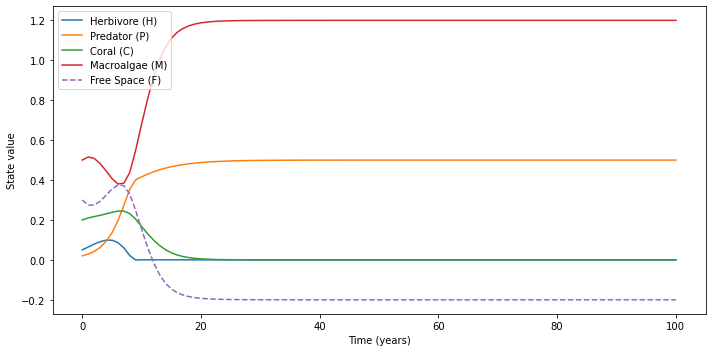

In [10]:
# Time axis (years)
numyears = parameters_dict['numyears']
t = np.arange(numyears + 1)

# Compute turf (implicit)
F_array = 1.0 - C_array - M_array

# ---- Plot state variables ----
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(t, H_array, label='Herbivore (H)')
ax.plot(t, P_array, label='Predator (P)')
ax.plot(t, C_array, label='Coral (C)')
ax.plot(t, M_array, label='Macroalgae (M)')
ax.plot(t, F_array, label='Free Space (F)', linestyle='--')

ax.set_xlabel("Time (years)")
ax.set_ylabel("State value")
ax.legend()

plt.tight_layout()
plt.show()

## Constraining to 0-1

In [11]:
def project_benthic(C, M):
    C = max(C, 0.0)
    M = max(M, 0.0)

    total = C + M
    if total > 1.0:
        C = C / total
        M = M / total

    return C, M


In [12]:
def dNdt(H, P, C, M, parameters_dict):

    #Herbivore parameters:
    r_H = parameters_dict['r_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']

    #Predator parameters:
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']

    #Coral-Algae parameters:
    r_C = parameters_dict['r_C']
    r_M = parameters_dict['r_M']
    a = parameters_dict['a']
    d_C = parameters_dict['d_C']
    g_H = parameters_dict['g_H']

    # Habitat-limited K for herbivores (scaled form)
    K_H = max(C, 1e-12)

    # Safe denominator for (1 - C)
    denom_1mC = max(1.0 - C, 1e-12)

    dH = r_H*H*(1 - H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H
    dP = r_P*P*(1 - P/K_P) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P

    dC = r_C*C*(1 - C - M) - a*C*M - d_C*C
    dM = r_M*M*(1 - C - M) + a*C*M - g_H*H/denom_1mC

    return dH, dP, dC, dM

In [13]:
def RK2(H, P, C, M, parameters_dict, dt=1.0):
    H_init = H
    P_init = P
    C_init = C
    M_init = M
    
    dH1, dP1, dC1, dM1 = dNdt(H, P, C, M, parameters_dict)
    
    H1 = H + 0.5*dt*dH1
    P1 = P + 0.5*dt*dP1
    C1 = C + 0.5*dt*dC1
    M1 = M + 0.5*dt*dM1
    
    dH2, dP2, dC2, dM2 = dNdt(H1, P1, C1, M1, parameters_dict)
    
    dH_ave = (dH1 + dH2)/2 
    dP_ave = (dP1 + dP2)/2 
    dC_ave = (dC1 + dC2)/2
    dM_ave = (dM1 + dM2)/2
    
    H = H_init + dt*dH_ave
    P = P_init + dt*dP_ave
    C = C_init + dt*dC_ave
    M = M_init + dt*dM_ave
    
    # Enforce benthic constraints (guarantees F in [0,1])
    C, M = project_benthic(C, M)

    # Optional: keep fish non-negative
    H = max(H, 0.0)
    P = max(P, 0.0)
    
    #Harvest
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    return H, P, C, M, herbivore_harvest, predator_harvest

In [14]:
def run_model(INIT_H, INIT_P, INIT_C, INIT_M, parameters_dict):
    
    numyears = parameters_dict['numyears']
    dt = parameters_dict.get('dt', 0.01)       # years per step
    steps_per_year = int(round(1.0 / dt))
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    C_array = np.zeros(numyears+1)
    M_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    
    H = INIT_H
    P = INIT_P
    C = INIT_C
    M = INIT_M
    
    C, M = project_benthic(C, M)
    H = max(H, 0.0)
    P = max(P, 0.0)
    
    H_array[0] = H
    P_array[0] = P
    C_array[0] = C
    M_array[0] = M
    
    for year in np.arange(0, numyears):
        
        for _ in range(steps_per_year):
            H, P, C, M, Hh, Ph = RK2(H, P, C, M, parameters_dict, dt=dt)
        
        H_array[year+1] = H
        P_array[year+1] = P
        C_array[year+1] = C
        M_array[year+1] = M
        H_harvest_array[year+1] = Hh
        P_harvest_array[year+1] = Ph
    
    return H_array, P_array, C_array, M_array, H_harvest_array, P_harvest_array

In [16]:
# Run model simulation
numyears = 100  # years (your RK2/run_model likely uses dt = 1 year per step)


# Herbivore parameters:
r_H = 0.49        # s in paper (yr^-1)  
theta_H = 0.0     # paper doesn't include immigration for parrotfish
q_H = 1.0         # map fishing mortality f onto E_H via q_H*E_H
E_H = 0.0         # this IS f in the paper; try 0.0, 0.25, etc.

# Coral–Algae parameters in your notation:
r_C = 1.0         # r in paper (yr^-1) 
r_M = 0.8       # gamma in paper (yr^-1)
a = 0.1           # a in paper (yr^-1)
d_C = 0.44        # d in paper (yr^-1)
g_H = 1.0         # grazing scaling; paper sets gmax=1 in scaled formulation

# Predator parameters:
r_P = 0.2         # predator intrinsic growth (choose/tune)
K_P = 0.5         # predator carrying capacity in same scaling as P (choose/tune)
theta_P = 0.0     # predator immigration
q_P = 1.0         # predator harvest proportionality
E_P = 0.0         # predator fishing effort

# Predation functional response parameters (your terms)
c = 0.4           # prey (parrotfish) mortality from predator (choose/tune)
b = 0.4           # predator gain from prey (choose/tune)
d = 0.05          # half-saturation constant (since H is scaled 0..1, keep this small)

dt = 0.01

parameters_dict = {
    'numyears': numyears,
    'dt': dt,

    # Herbivore (parrotfish)
    'r_H': r_H,
    'theta_H': theta_H,
    'q_H': q_H,
    'E_H': E_H,

    # Predator
    'r_P': r_P,
    'K_P': K_P,
    'theta_P': theta_P,
    'q_P': q_P,
    'E_P': E_P,

    # Predator-prey coupling
    'c': c,
    'b': b,
    'd': d,

    # Coral-algae
    'r_C': r_C,
    'r_M': r_M,
    'a': a,
    'd_C': d_C,
    'g_H': g_H,
}


In [17]:
# Initial conditions (scaled)
H0 = 0.05   # parrotfish ~ initial grazing level 0.05
P0 = 0.02   # predator small initial abundance
C0 = 0.20   # coral cover
M0 = 0.50   # macroalgae cover (pick a plausible starting value)

H_array, P_array, C_array, M_array, H_harvest_array, P_harvest_array = run_model(
    H0, P0, C0, M0, parameters_dict
)

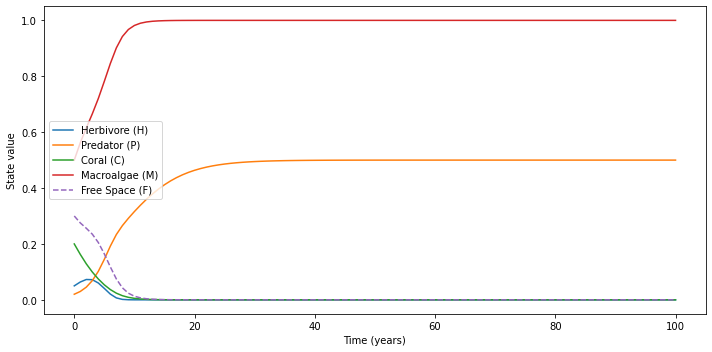

In [18]:
# Time axis (years)
numyears = parameters_dict['numyears']
t = np.arange(numyears + 1)

# Compute turf (implicit)
F_array = 1.0 - C_array - M_array

# ---- Plot state variables ----
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(t, H_array, label='Herbivore (H)')
ax.plot(t, P_array, label='Predator (P)')
ax.plot(t, C_array, label='Coral (C)')
ax.plot(t, M_array, label='Macroalgae (M)')
ax.plot(t, F_array, label='Free Space (F)', linestyle='--')

ax.set_xlabel("Time (years)")
ax.set_ylabel("State value")
ax.legend()

plt.tight_layout()
plt.show()